In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

### Необходимые библиотеки

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
from torch.nn import functional

In [7]:
import torchvision
import torchvision.transforms as transforms

In [8]:
from torchvision.transforms import InterpolationMode

In [ ]:
# наша библиотека
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [ ]:
# наша библиотека
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [11]:
from svetlanna.transforms import ToWavefront

In [ ]:
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [13]:
from tqdm import tqdm

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline

**<span style="color:red">ПРЕДУПРЕЖДЕНИЕ.</span>** для запуска этого примера необходимо установить с [официального сайта](https://pytorch.org/get-started/locally/) версию `torch`, поддерживающую вычисления на CUDA.

Также с [официального сайта NVIDIA](https://developer.nvidia.com/cuda-toolkit) необходимо установить драйвера CUDA. 

**<span style="color:red">ВАЖНО:</span>** версия torch с поддержкой CUDA и версия драйверов CUDA должны совпадать. Версия драйверов CUDA зависит от видеокарты, на которой планируется запуск примера.

# 1. Параметры симуляции

## 1.1 Создание параметров симуляции

In [ ]:
working_frequency = 0.4 * 1e12 # [Гц]
c_const = 299_792_458  # [м / с]
working_wavelength = c_const / working_frequency  # [м]

#размер нейрона
neuron_size = 0.53 * working_wavelength  # [м]

DETECTOR_SIZE = (1024, 1024)
# зона, в которой будут обновляться веса по ходу тренировки

# количество нейронов
x_layer_nodes = DETECTOR_SIZE[1] * 1
y_layer_nodes = DETECTOR_SIZE[0] * 1
# Комментарий: Тот же размер, что и предложен!

# физический размер каждого слоя [см]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size  # [m]

In [ ]:
print(f'длина волны = {working_wavelength * 1e6:.3f} um')
print(f'размер нейрона = {neuron_size * 1e6:.3f} um')
print(f'размер слоя в нейронах: {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')
print(f'Размер слоя в см: {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

lambda = 749.481 um
neuron size = 397.225 um
Layer size (in neurons): 1024 x 1024 = 1048576
Layer size (in cm): 40.67584070144 x 40.67584070144


## 1.2 Создание расчетной сетки

In [ ]:
SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # только одна длина волны!
    }
)

# 2. Подготовка выборки данных (Инженер данных)

## 2.1. [Выборка данных MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset): загрузка и преобразование в волновые фронты

In [ ]:
# инициализация папки для данных
MNIST_DATA_FOLDER = './data'  # папка для данных MNIST

### 2.1.1. Загрузка тренировочной и тестовой выборок изображений

In [ ]:
# Тренировочная выборка MNIST
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # для тренировочной выборки
    download=True,
)

print(f'Размер тренировочной выборки: {len(mnist_train_ds)}')

Train data: 60000


In [ ]:
# Тестовая выборка MNIST
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # для тестовой выборки
    download=True,
)

print(f'Размер тестовой выборки: {len(mnist_test_ds)}')

Test data : 10000


### 2.1.2. Детектор

`DetectorProcessor` в нашей библиотеке используется для обработки информации на детекторе. Например, для текущей задачи `DetectorProcessor` должен возвращать только 10 значений, каждое из которых соответствует определенной цифре.

 Определим объект типа “Detector”

In [22]:
import src.detector_segmentation as detector_segmentation

In [ ]:
number_of_classes = 10

detector_segment_size = 22 * working_wavelength

# размер сегмента в нейронах
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# каждый сегмент размера (y_segment_nodes, x_segment_nodes)

y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9


# Эта маска будет использоваться для генерации целевого изображения для каждой цифры
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # размер детектора или апертуры (в середине детектора)
    SIM_PARAMS
)
# Целевое изображение: нули везде, кроме необходимой зоны, отвечающей за метку!

### 2.1.3. Преобразование изображений в волновые фронты

In [ ]:
# выбор типа модуляции
MODULATION_TYPE = 'amp'  # используем ТОЛЬКО амплитуду для кодирования каждого изображения в волновом фронте!

resize_y = int(DETECTOR_SIZE[0] / 3)
resize_x = int(DETECTOR_SIZE[1] / 3)  # форма для transforms.Resize

# отступы по OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# отступы по OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # параметры для transforms.Pad

# собираем все преобразования!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # левый отступ
              pad_top,  # верхний отступ
              pad_right,  # правый отступ
              pad_bottom  # нижний отступ
          ),
          fill=0,
      ),  # отступы!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- выбор типа модуляции!!!
  ]
)

**<span style="color:red">Комментарий.</span>** в этой части кода`dataset.getitem()` вернет пару `Wavefront`, в котором закодировано само изображений цифры, и целевую метку(число от 0 до 9). В течение процесса тренировки в качестве функции потерь будет использована функция среднеквадратической ошибки,также будет сгенерировано изображение детектора цели на основе зон детектора (будет инициализировано позже в 3.1.3).

In [ ]:
# Тренировочная выборка MNIST в виде волновых фронтов
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # выборка изображений
    transformations=image_transform_for_ds,  # преобразование изображений
    sim_params=SIM_PARAMS,  #   параметры симуляции
    target='detector',
    detector_mask=DETECTOR_MASK
)

# Тестовая выборка MNIST в виде волновых фронтов
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # выборка изображений
    transformations=image_transform_for_ds,  # преобразование изображений
    sim_params=SIM_PARAMS,  # параметры симуляции
    target='detector',
    detector_mask=DETECTOR_MASK
)

# 3. Оптическая нейронная сеть

Создадим нейронную сеть, которая состоит из 512-ти дифракционных слоев. 5 слоев будут подвержены обучения: 2 в начали оптической системы, 2 в конце и один в середине.

> Расстояние между слоями фиксировано и равно $40$ $\lambda$

## 3.1 Параметры нейронной сети

In [ ]:
NUM_OF_DIFF_LAYERS = 5  # количество дифракционных слоев в нейронной сети, которые будут обучены
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [м] - расстояние между дифракционными слоями
print(f'Расстояние между слоями равно {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

MAX_PHASE = 2 * torch.pi  # максимальный набег фазы для фазовых масок

FREESPACE_METHOD = 'AS'  # мы используем другой метод в отличие от [2]!!!

INIT_PHASE = torch.pi  # начальные значения для фазовых масок

Distance between layers is 2.998 cm


## 3.2 Архитектура

**<span style="color:red">Комментарий:</span>**
Здесь мы используем класс `ConstrainedParameter`, который использует функцию сигмоиды для ограничения параметров в ходе обучения.

**<span style="color:red">Комментарий:</span>** оптическая система заканчивается детектором `Detector`, который возвращает тензор выходных распределений интенсивности для каждого входного волнового фронта `Wavefront`.

In [ ]:
def set_setup(
    total_number_of_layers: int,
    number_of_layers_at_the_beginning: int,
):

    global FREE_SPACE_DISTANCE, MAX_PHASE, FREESPACE_METHOD, INIT_PHASE
    global SIM_PARAMS

    elements_list = []

    free_space = elements.FreeSpace(
        simulation_parameters=SIM_PARAMS,
        distance=FREE_SPACE_DISTANCE,
        method=FREESPACE_METHOD
    )

    x_nodes, y_nodes = SIM_PARAMS.axes_size(axs=('W', 'H'))
    const_mask = torch.ones(size=(y_nodes, x_nodes)) * INIT_PHASE

    trainable_diffractive_layer = elements.DiffractiveLayer(
        simulation_parameters=SIM_PARAMS,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=MAX_PHASE
        ),
    )

    untrained_diffractive_layer = elements.DiffractiveLayer(
        simulation_parameters=SIM_PARAMS,
        mask=const_mask,  # Здесь мы не используем ConstrainedParameter, чтобы не ограничивать значения маски
    )

    elements_list.append(free_space)

    for _ in range(2):
        elements_list.append(trainable_diffractive_layer)
        elements_list.append(free_space)

    for _ in range(number_of_layers_at_the_beginning):
        elements_list.append(untrained_diffractive_layer)
        elements_list.append(free_space)

    elements_list.append(trainable_diffractive_layer)
    elements_list.append(free_space)

    for _ in range(total_number_of_layers - number_of_layers_at_the_beginning):
        elements_list.append(untrained_diffractive_layer)
        elements_list.append(free_space)

    for _ in range(2):
        elements_list.append(trainable_diffractive_layer)
        elements_list.append(free_space)

     # Добавляем детектор в конце оптической системы
    elements_list.append(
        Detector(
            simulation_parameters=SIM_PARAMS,
            func='intensity'  # детектор возвращает интенсивность
        )
    )

    return LinearOpticalSetup(elements=elements_list)

In [28]:
NUM_OF_DIFF_LAYERS_NO_TRAIN = 507
NUM_OF_DIFF_LAYERS_BEGINNING = 253

In [29]:
optical_setup = set_setup(
    total_number_of_layers=NUM_OF_DIFF_LAYERS_NO_TRAIN,
    number_of_layers_at_the_beginning=NUM_OF_DIFF_LAYERS_BEGINNING
)

c:\Users\semen.chugunov\Desktop\ex\SVETlANNa.docs\.venv\Lib\site-packages\svetlanna\elements\free_space.py:152: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Nx*dx product.
  warn(
c:\Users\semen.chugunov\Desktop\ex\SVETlANNa.docs\.venv\Lib\site-packages\svetlanna\elements\free_space.py:158: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Ny*dy product.
  warn(


## 3.3 Обработка детектором

In [ ]:
CALCULATE_ACCURACIES = True

# создаем обработчик детектора, который будет использоваться для вычисления точности
if CALCULATE_ACCURACIES:
    detector_processor = DetectorProcessorClf(
        simulation_parameters=SIM_PARAMS,
        num_classes=number_of_classes,
        segmented_detector=DETECTOR_MASK,
    )
else:
    detector_processor = None

## 3.4 Подготовка к тренировки нейронной сети

In [ ]:
train_bs = 32  # размер батча для тренировочной выборки
val_bs = 16  # размер батча для валидационной выборки

LR = 1e-3  # шаг

loss_func_clf = nn.MSELoss()  # по-умолчанию: reduction='mean'
loss_func_name = 'MSE'

In [ ]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # параметры нейронной сети!
        lr=LR
    )

In [ ]:
# разделяем  выборку данных mnist на тренировочную и валидационную
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=mnist_wf_train_ds,
    lengths=[55000, 5000],  # размер взят из статьи
    generator=torch.Generator().manual_seed(178)  # для воспроизводимости
)

train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

## 3.5 Циклы для тренировки и оценки

In [ ]:
def onn_train_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR нужен только для вычисления точности!
    loss_func, optimizer,
    device='cuda', show_process=False
):
    """
    Function to train `optical_net` (classification task)
    ...

    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        optimizer: torch.optim
            Optimizer...
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.

    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.train()  # активация режима тренировки для модели
    batches_losses = []  # для хранения потерь для каждого батча
    batches_accuracies = []  # для хранения точности для каждого батча

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()

        # прямое распространение через нейронную сеть
        detector_output = optical_net(batch_wavefronts)

        # вычисление потерь для батча
        loss = loss_func(detector_output, batch_targets)

        loss.backward()
        optimizer.step()

        # точность
        if CALCULATE_ACCURACIES:
            # обработка изображения детектора
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_output)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # сохраняем потери и точность для каждого батча
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy

In [ ]:
def onn_validate_mse(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR требуется!
    loss_func,
    device='cuda', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...

    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.

    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # активация режима валидации для модели
    batches_losses = []  # для хранения потерь для каждого батча
    batches_accuracies = []  # для хранения точности для каждого батча

    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):
        batch_size = batch_wavefronts.size()[0]

        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)

        with torch.no_grad():
            detector_outputs = optical_net(batch_wavefronts)
            # вычисление потерь для батча
            loss = loss_func(detector_outputs, batch_targets)

        # точность
        if CALCULATE_ACCURACIES:
            # обработка изображения детектора
            batch_labels = detector_processor_clf.batch_forward(batch_targets).argmax(1)
            batch_probas = detector_processor_clf.batch_forward(detector_outputs)

            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()

            correct_preds += batch_correct_preds
            size += batch_size

        # сохраняем потери и точность для каждого батча
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.

    return batches_losses, batches_accuracies, epoch_accuracy

# 4. Тренировка оптической нейронной сети

## 4.1. Перед тренировкой: перенос созданных объектов на графический процессор

Если корректно установлены версия `torch`, поддерживающая вычисления с помощью cuda, и драйвера CUDA(Драйверы NVIDIA, CUDA Toolkit), то для совершения вычислений будет доступен GPU.

Выбрать устройство для вычислений можно с использованием кода в ячейке ниже:

In [36]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cuda')

In [37]:
optical_setup.net = optical_setup.net.to(DEVICE)
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
detector_processor = detector_processor.to(DEVICE)

## 4.2. Обучение

In [ ]:
n_epochs = 6
print_each = 2  # выводить информацию каждые `print_each` эпох

scheduler = None  # регулятор для настройки шага обучения во время тренировки


# определяем оптимизатор
optimizer_clf = get_adam_optimizer(optical_setup.net)

In [ ]:
train_epochs_losses = []
val_epochs_losses = []  # для хранения потерь

train_epochs_acc = []
val_epochs_acc = []  # для хранения точности

torch.manual_seed(98)

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # обучение
    start_train_time = time.time()  # стартовое время эпохи (тренировка)
    train_losses, _, train_accuracy = onn_train_mse(
        optical_setup.net,  # созданная архитектура оптической сети
        train_wf_loader,  # загрузчик тренировочной выборки
        detector_processor,  # обработчик детектора
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # тренировка модели
    mean_train_loss = np.mean(train_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # информация о тренировке
        print('Результаты тренировки')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tТочность : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # валидация
    start_val_time = time.time()  # стартовое время эпохи (валидация)
    val_losses, _, val_accuracy = onn_validate_mse(
        optical_setup.net,  # созданная архитектура оптической сети
        val_wf_loader,  # загрузчик валидационной выборки
        detector_processor,  # обработчик детектора
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # оценка модели
    mean_val_loss = np.mean(val_losses)

    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # информация о валидации
        print('Результаты валидации')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tТочность: {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')

    if scheduler:
        scheduler.step(mean_val_loss)

    # сохранение потерь
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # сохранение точности
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|██████████| 1719/1719 [8:29:39<00:00, 17.79s/it]  


Training results
	MSE : 0.001728
	Accuracy : 26.9 %
	------------   30579.48 s


validation: 100%|██████████| 313/313 [22:58<00:00,  4.41s/it]


Validation results
	MSE : 0.001599
	Accuracy : 27.0 %
	------------   1378.90 s
Epoch #2: 

train: 100%|██████████| 1719/1719 [8:39:04<00:00, 18.12s/it]  


Training results
	MSE : 0.001564
	Accuracy : 27.6 %
	------------   31144.66 s


validation: 100%|██████████| 313/313 [25:59<00:00,  4.98s/it]


Validation results
	MSE : 0.001536
	Accuracy : 30.1 %
	------------   1559.21 s
Epoch #4: 

train: 100%|██████████| 1719/1719 [12:18:27<00:00, 25.78s/it]  


Training results
	MSE : 0.001460
	Accuracy : 52.9 %
	------------   44308.11 s


validation: 100%|██████████| 313/313 [28:33<00:00,  5.47s/it]


Validation results
	MSE : 0.001439
	Accuracy : 58.4 %
	------------   1713.50 s
Epoch #6: 

train: 100%|██████████| 1719/1719 [8:04:32<00:00, 16.91s/it]  


Training results
	MSE : 0.001376
	Accuracy : 66.0 %
	------------   29072.57 s


validation: 100%|██████████| 313/313 [17:53<00:00,  3.43s/it]

Validation results
	MSE : 0.001359
	Accuracy : 68.0 %
	------------   1073.64 s


## 4.3. Кривые обучения(среднеквадратическая ошибка MSE и точность)

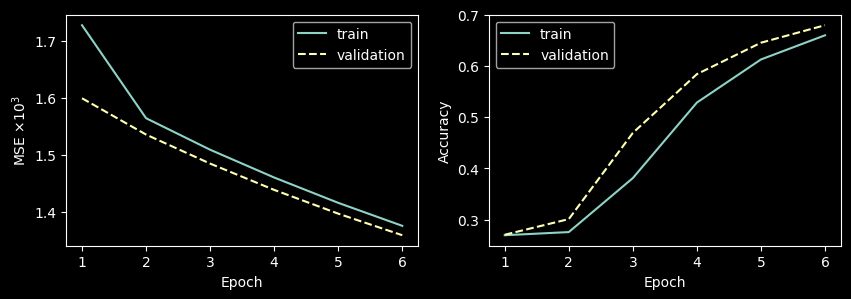

In [ ]:
# строим кривую обучения
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses) * 1e3, label='тренировка')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses) * 1e3, linestyle='dashed', label='валидация')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='тренировка')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='валидация')

axs[0].set_ylabel(loss_func_name + r' $\times 10^3$')
axs[0].set_xlabel('эпоха')
axs[0].legend()

axs[1].set_ylabel('точность')
axs[1].set_xlabel('эпоха')
axs[1].legend()

plt.show()

In [ ]:
# массив со всеми потерями и точностью
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

## 4.4. Обученные фазовые маски

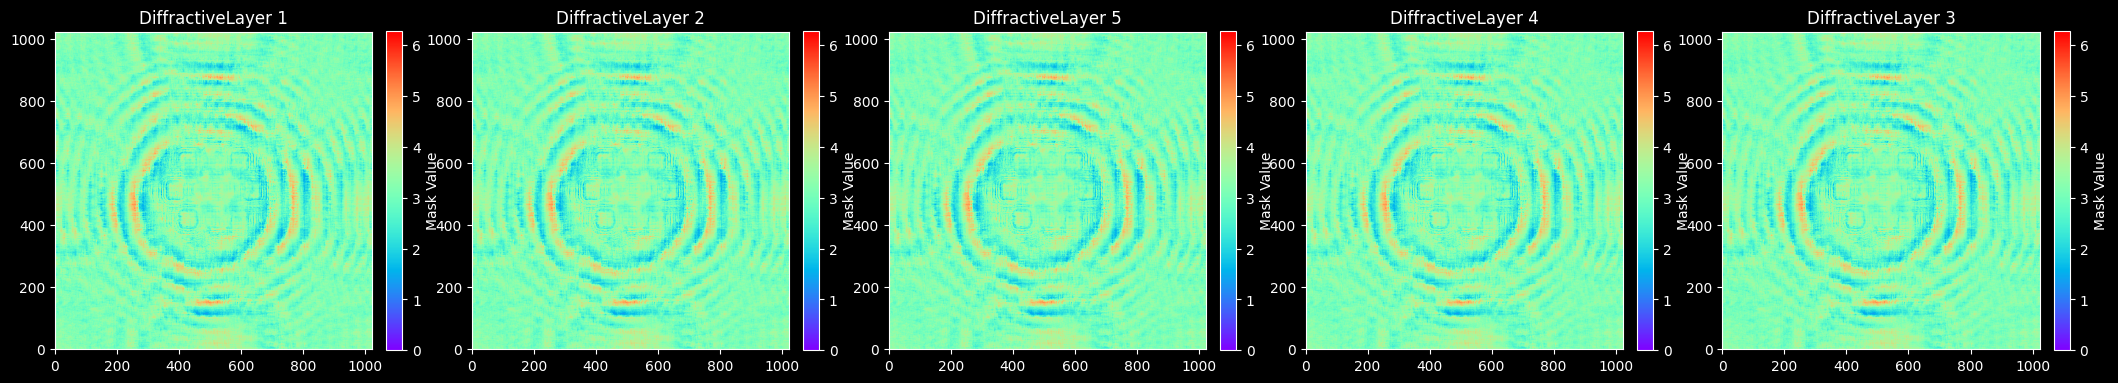

In [42]:
# Индексы объектов, которые нужно визуализировать
target_indices = {1, 3, 511, 1021, 1023}

# Определяем количество колонок и строк для визуализации
n_cols = len(target_indices)  # Количество колонок равно числу целевых индексов
n_rows = 1

# Создаем фигуру для визуализации
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5.2, n_rows * 4.6))

cmap = 'rainbow'  # Цветовая карта для визуализации
count = 1
# Перебираем слои в optical_setup
for ind_layer, layer in enumerate(optical_setup.net.to(torch.device("cpu"))):
    if ind_layer in target_indices and isinstance(layer, elements.DiffractiveLayer):


        # Определяем текущий subplot
        ax_this = axs[list(target_indices).index(ind_layer)]

        # Добавляем заголовок с индексом слоя
        ax_this.set_title(f'DiffractiveLayer {count}')
        count += 1

        # Получаем mask для визуализации
        mask_to_visualize = layer.mask.detach()

        # Визуализируем mask
        im = ax_this.imshow(
            mask_to_visualize, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.set_xlim([x_frame, x_layer_nodes - x_frame])
        ax_this.set_ylim([y_frame, y_layer_nodes - y_frame])

        cbar = fig.colorbar(im, ax=ax_this, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Mask Value')

plt.show()

## 4.5 Сохранение результатов

#### Пути для сохранения

In [43]:
RESULTS_FOLDER = f'models/reproduced_results/MNIST_MSE_Ozcan_2018-2020_GPU_{512}_DL_{DETECTOR_SIZE[0]}x{DETECTOR_SIZE[1]}_grid'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [ ]:
# путь к файлу с моделью
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net_gpu.pth'
# путь к файлу с потерями
losses_filepath = f'{RESULTS_FOLDER}/training_curves_gpu.csv'

#### Сохранение обученных весов и модели

In [ ]:
# сохранение модели
torch.save(optical_setup.net.state_dict(), model_filepath)

In [ ]:
# сохранение потерь
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)